In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import socket
import threading
import pickle  # For serializing models

In [ ]:
import os
print(os.listdir('/content/'))  # Or your directory path

['.config', 'sample_data']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
 # Upload datasets if needed
try:
    train_data = pd.read_csv('/content/KDDTrain+.txt', sep='\t', header=None)
    test_data = pd.read_csv('/content/KDDTest+.txt', sep='\t', header=None)
    print("Datasets loaded.")
except FileNotFoundError:
    print("Uploading datasets...")
    uploaded = files.upload()
    train_data = pd.read_csv('/content/KDDTrain+.txt', sep='\t', header=None)
    test_data = pd.read_csv('/content/KDDTest+.txt', sep='\t', header=None)
# Preprocessing
columns = [f'feature_{i}' for i in range(41)] + ['label']
train_data.columns = columns
test_data.columns = columns
le_label = LabelEncoder()
train_data['label'] = le_label.fit_transform(train_data['label'])
test_data['label'] = le_label.transform(test_data['label'])
categorical_cols = ['feature_1', 'feature_2', 'feature_3']
le_cat = LabelEncoder()
for col in categorical_cols:
    train_data[col] = le_cat.fit_transform(train_data[col])
    test_data[col] = le_cat.transform(test_data[col])
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Datasets loaded and preprocessed.")

Uploading datasets...


NameError: name 'files' is not defined

In [ ]:
# Load datasets (NSL-KDD format: 41 features + label)
columns = [f'feature_{i}' for i in range(41)] + ['label']
train_data = pd.read_csv('KDDTrain+.txt', header=None, names=columns)
test_data = pd.read_csv('KDDTest+.txt', header=None, names=columns)
# Encode labels (normal=0, attack=1)
le = LabelEncoder()
train_data['label'] = le.fit_transform(train_data['label'])
test_data['label'] = le.transform(test_data['label'])
# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Datasets loaded and preprocessed.")

ValueError: could not convert string to float: 'tcp'


--- Part 1: EDA ---
Training dataset shape: (125973, 41)
Testing dataset shape: (22544, 41)
Summary statistics for training dataset:
          feature_3     feature_4      feature_5      feature_6  \
count  1.259730e+05  1.259730e+05  125973.000000  125973.000000   
mean   4.556674e+04  1.977911e+04       0.000198       0.022687   
std    5.870331e+06  4.021269e+06       0.014086       0.253530   
min    0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    0.000000e+00  0.000000e+00       0.000000       0.000000   
50%    4.400000e+01  0.000000e+00       0.000000       0.000000   
75%    2.760000e+02  5.160000e+02       0.000000       0.000000   
max    1.379964e+09  1.309937e+09       1.000000       3.000000   

           feature_7      feature_8      feature_9     feature_10  \
count  125973.000000  125973.000000  125973.000000  125973.000000   
mean        0.000111       0.204409       0.001222       0.395736   
std         0.014366       2.149968       0.045239     

ValueError: The number of FixedLocator locations (22), usually from a call to set_ticks, does not match the number of labels (2).

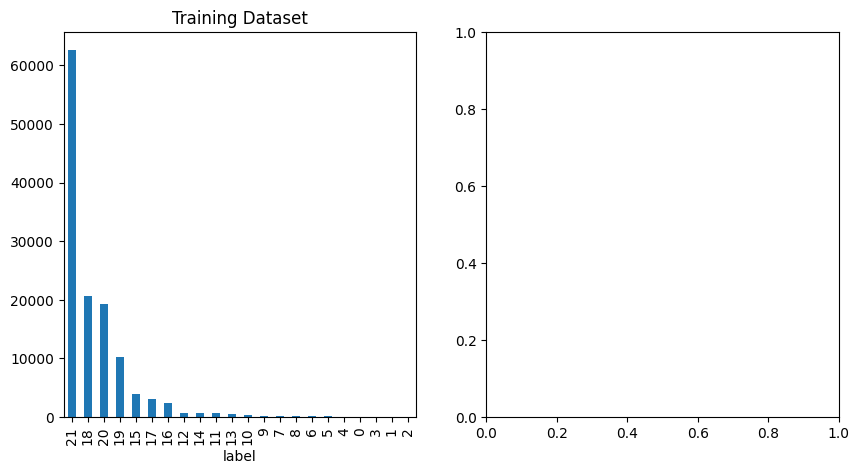

In [ ]:
# Part 1: Exploratory Data Analysis (EDA)
print("\n--- Part 1: EDA ---")
print(f"Training dataset shape: {X_train.shape}")
print(f"Testing dataset shape: {X_test.shape}")
print("Summary statistics for training dataset:")
print(train_data.describe())
# Percentage distribution of normal and attack records
train_label_counts = y_train.value_counts()
print(f"Training: Normal: {train_label_counts[0]/len(y_train)*100:.2f}%, Attack: {train_label_counts[1]/len(y_train)*100:.2f}%")
# Bar chart for normal vs attack in train/test
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_label_counts.plot(kind='bar', ax=ax[0], title='Training Dataset')
ax[0].set_xticklabels(['Normal', 'Attack'])
test_label_counts = y_test.value_counts()
test_label_counts.plot(kind='bar', ax=ax[1], title='Testing Dataset')
ax[1].set_xticklabels(['Normal', 'Attack'])
plt.show()
# Correlation heatmap (using a subset for visibility)
corr = train_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Training Dataset)')
plt.show()
# Bar chart for attack types (assuming 'label' has attack subtypes; simplify to normal/attack)
# For detailed attack types, you'd need to decode; here, just normal vs attack
attack_types = train_data['label'].value_counts()
attack_types.plot(kind='bar', title='Attack Types Distribution (Training)')
plt.show()


In [ ]:
# Part 2: ML Model Implementation
print("\n--- Part 2: ML Models ---")
# Model 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_pred):.4f}")
print(f"Recall: {recall_score(y_test, rf_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, rf_pred):.4f}")

In [ ]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
print("SVM Metrics:")
print(f"Accuracy: {accuracy_score(y_test, svm_pred):.4f}")
print(f"Precision: {precision_score(y_test, svm_pred):.4f}")
print(f"Recall: {recall_score(y_test, svm_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, svm_pred):.4f}")

In [ ]:
# Part 3: Neural Network Model (PyTorch)
print("\n--- Part 3: Neural Network ---")
class IDSNet(nn.Module):
    def __init__(self, input_size):
        super(IDSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
# Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
nn_model = IDSNet(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Train
epochs = 10
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate
nn_model.eval()
with torch.no_grad():
    nn_outputs = nn_model(X_test_tensor)
    _, nn_pred = torch.max(nn_outputs, 1)
    nn_pred = nn_pred.numpy()
print("Neural Network Metrics:")
print(f"Accuracy: {accuracy_score(y_test, nn_pred):.4f}")
print(f"Precision: {precision_score(y_test, nn_pred):.4f}")
print(f"Recall: {recall_score(y_test, nn_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, nn_pred):.4f}")

# Part 4: Model Comparison and Analysis
print("\n--- Part 4: Model Comparison ---")
models = ['Random Forest', 'SVM', 'Neural Network']
accuracies = [accuracy_score(y_test, rf_pred), accuracy_score(y_test, svm_pred), accuracy_score(y_test, nn_pred)]
precisions = [precision_score(y_test, rf_pred), precision_score(y_test, svm_pred), precision_score(y_test, nn_pred)]
recalls = [recall_score(y_test, rf_pred), recall_score(y_test, svm_pred), recall_score(y_test, nn_pred)]
f1s = [f1_score(y_test, rf_pred), f1_score(y_test, svm_pred), f1_score(y_test, nn_pred)]
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1s
})
print(comparison_df)

# Discussion: Neural Network often performs best due to learning complex patterns, but requires more computation. Challenges: Data imbalance, overfitting. Improvements: Use more data, hyperparameter tuning.
# Part 5: Real-Time IDS Prototype
print("\n--- Part 5: Real-Time IDS Prototype ---")
# Use Random Forest as the trained model for predictions
def predict_traffic(data):
    data_scaled = scaler.transform([data])
    pred = rf_model.predict(data_scaled)[0]
    return "Normal" if pred == 0 else "Anomalous"

# Server
def server():
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind(('localhost', 12345))
    server_socket.listen(1)
    print("Server listening...")
    conn, addr = server_socket.accept()
    print(f"Connected to {addr}")
    while True:
        data = conn.recv(1024)
        if not data:
            break
        sample = pickle.loads(data)  # Assume client sends pickled list of 41 features
        result = predict_traffic(sample)
        conn.send(result.encode())
    conn.close()

# Client (simulates sending sample data)
def client():
    client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_socket.connect(('localhost', 12345))
    sample_data = X_test.iloc[0].tolist()  # Send first test sample
    client_socket.send(pickle.dumps(sample_data))
    response = client_socket.recv(1024).decode()
    print(f"Prediction: {response}")
    client_socket.close()
# Run server and client in threads
threading.Thread(target=server).start()
import time
time.sleep(1)  # Wait for server to start
client()
print("Coursework code execution complete. Prepare report and video based on outputs.")
